## Import Modules

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import scipy.integrate as intg
from scipy.integrate import quad
from scipy.special import sici
from scipy.special import erf
from scipy.optimize import curve_fit, minimize, leastsq
from scipy import stats

from dark_emulator import darkemu
from dark_emulator.pyfftlog_interface import pyfftlog_class
emu = darkemu.base_class()


initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [2]:
import logging
import time
import warnings
from functools import lru_cache
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.interpolate import UnivariateSpline as uspline
from scipy.stats import poisson


## Halo Functions and Fitting Functions

In [3]:
#Fourier transforms

def slow_fourier_transform(fn, t, v):
    dt = t[1] - t[0]
    return (fn[:, None] * np.exp(-2j * np.pi * t[:, None] * v)).sum(0) * dt

def slow_FT_3D(fn, k, r):
    fFT = np.zeros(len(k)).astype('complex')
    fn2 = 0.5*(fn[1:] + fn[:-1])
    r2 = 0.5*(r[1:] + r[:-1])
    dr = np.diff(r)
    for i in range(len(k)):
        fFT[i] = np.sum((4*np.pi*r2*fn2*np.exp(-1j*r2*k[i])/k[i])*dr/((2*np.pi)**3))
    return fFT

def slow_Ifourier_transform(fn, t, v):
    dt = t[1] - t[0]
    return (fn[:, None] * np.exp(2j * np.pi * t[:, None] * v)).sum(0) * dt

def slow_IFT_3D(fn, k, r):
    iFFT = np.zeros(len(k)).astype('complex')
    fn2 = 0.5*(fn[1:] + fn[:-1])
    k2 = 0.5*(k[1:] + k[:-1])
    dk = np.diff(k)
    for i in range(len(r)):
        iFFT[i] = np.sum((4*np.pi*k2*fn2*np.exp(-1j*k2*r[i])/r[i])*dk/((2*np.pi)**3))
    return iFFT

In [4]:
#code taken from Halomod tools.py, https://github.com/halomod/halomod/tree/dev/src/halomod (Murray 2020)

def simpson_FT(fn, k, r):
    p_fn = np.zeros_like(fn)
    
    minsteps = 8

    # set min_k, 1e-6 should be good enough
    mink = 1e-6
    temp_min_k = 1.0

    for i, k_i in enumerate(k):
        # getting maxk here is the important part. It must be a half multiple of
        # pi/r to be at a "zero", it must be >1 AND it must have a number of half
        # cycles > 38 (for 1E-5 precision).

        min_k = (2*np.ceil((temp_min_k*k_i/np.pi - 1)/2) + 0.5)*np.pi/k_i
        maxk = max(501.5*np.pi/k_i, min_k)

        # Now we calculate the requisite number of steps to have a good dk at hi-k.
        nk = np.ceil( np.log(maxk/mink)/np.log(maxk/(maxk - np.pi/(minsteps*k_i))) )

        lnk, dlnk = np.linspace(np.log(mink), np.log(maxk), int(nk), retstep=True)
        fn_i = np.interp(lnk, r, fn)
        
        P = (4*np.pi*lnk*fn_i/k[i])
        integ = P*(np.exp(lnk)**2)*np.sin(np.exp(lnk) * k_i) / k_i

        p_fn[i] = (0.5/np.pi**2)*intg.simpson(integ, dx=dlnk)

    return p_fn


In [5]:
#code taken from Halomod tools.py, https://github.com/halomod/halomod/tree/dev/src/halomod (Murray 2020)

def power_to_corr_ogata(power,k, r, h=0.005, power_pos=(True,True),rtol=1e-3, atol=1e-15, _reverse=False):
    """
    Convert a 3D power spectrum to a correlation function.
    Uses Ogata's method (Ogata 2005) for Hankel Transforms in 3D.
    Parameters
    ----------
    power : np.ndarray
        The power spectrum to convert -- either 1D or 2D. If 1D, it is the power as a
        function of k. If 2D, the first dimension should be ``len(r)``, and the power
        to integrate is considered to be different for each ``r``.
    k : np.ndarray
        Array of same length as the last axis of ``power``, giving the fourier-space
        co-ordinates.
    r : np.ndarray
        The real-space co-ordinates to which to transform.
    h : int, optional
        Controls the spacing of the intervals (note the intervals are not equispaced).
        Smaller numbers give smaller intervals.
    power_pos : tuple of bool, optional
        Whether 'power' is definitely positive, at either end. If so, a slightly better
        extrapolation can be achieved.
    Notes
    -----
    See the `hankel <https://hankel.readthedocs.io>`_ documentation for details on the
    implementation here. This particular function is restricted to a spherical transform.
    """
    v = "kr"
    if _reverse:
        v = v[::-1]

    func = "corr" if _reverse else "power"

    # Optimal value of nmax, given h.
    nmax = int(3.2 / h)

    lnk = np.log(k)
    roots = np.arange(1, nmax + 1)
    t = h * roots
    s = np.pi * np.sinh(t)
    x = np.pi * roots * np.tanh(s / 2)

    dpsi = 1 + np.cosh(s)
    dpsi[dpsi != 0] = (np.pi * t * np.cosh(t) + np.sinh(s)) / dpsi[dpsi != 0]
    sumparts = np.pi * np.sin(x) * dpsi * x

    if power_pos[0] and not np.all(power.T[:2] > 0):
        power_pos = (False, power_pos[1])

    if power_pos[1] and not np.all(power.T[-2:] > 0):
        power_pos = (power_pos[0], False)

    def pfunc(logk, p):
        """An interpolation function for masked p(k)."""
        spl = spline(lnk, p, k=3)
        result = np.zeros_like(logk)
        inner_mask = (lnk.min() <= logk) & (logk <= lnk.max())
        result[inner_mask] = spl(logk[inner_mask])

        lower_mask = logk < lnk.min()
        if power_pos[0]:
            result[lower_mask] = np.exp(
                (np.log(p[1]) - np.log(p[0]))
                * (logk[lower_mask] - lnk[0])
                / (lnk[1] - lnk[0])
                + np.log(p[0])
            )
        else:
            result[lower_mask] = (p[1] - p[0]) * (logk[lower_mask] - lnk[0]) / (
                lnk[1] - lnk[0]
            ) + p[0]

        upper_mask = logk > lnk.max()
        if power_pos[1]:
            if p[-1] <= 0 or p[-2] <= 0:
                raise ValueError("Something went horribly wrong")
            result[upper_mask] = np.exp(
                (np.log(p[-1]) - np.log(p[-2])) * (logk[upper_mask] - lnk[-1])/(lnk[-1] - lnk[-2]) + np.log(p[-1]))
        else:
            result[upper_mask] = (p[-1] - p[-2]) * (logk[upper_mask] - lnk[-1]) / (lnk[-1] - lnk[-2]) + p[-1]

        return result

    out = np.zeros(len(r))

    warn_upper = True
    warn_lower = True
    warn_conv = True
    for ir, rr in enumerate(r):
        kk = x / rr

        summand = sumparts * pfunc(np.log(kk), power[ir] if power.ndim == 2 else power)
        cumsum = np.cumsum(summand)

        if kk.min() < k.min() and warn_lower:
            warnings.warn(f"In hankel transform, {func} at {v[1]}={rr:.2e} was extrapolated to "
                f"{v[0]}={kk.min():.2e}. Minimum provided was {k.min():.2e}. "
                f"Lowest value required is {x.min() / r.max():.2e}",
                stacklevel=2, )
            warn_lower = False

        # If all k values accessed weren't interpolated, just return it.
        if kk.max() <= k.max():
            out[ir] = cumsum[-1]
        else:
            # Check whether we have convergence at k.max
            indx = np.where(kk > k.max())[0][0]

            if np.isclose(cumsum[indx], cumsum[indx - 1], atol=atol, rtol=rtol):
                # If it converged in the non-extrapolated part, return that.
                out[ir] = cumsum[indx]
            else:
                # Otherwise, warn the user, and just return the full sum.
                if warn_upper:
                    warnings.warn(f"In hankel transform, {func} at {v[1]}={rr:.2e} was extrapolated to "
                        f"{v[0]}={kk.max():.2e}. Maximum provided was {k.max():.2e}. ",
                        stacklevel=2,)
                    warn_upper = False

                if (not np.isclose(cumsum[-1], cumsum[-2], atol=atol, rtol=rtol)
                    and warn_conv):
                    warnings.warn(
                        f"Hankel transform of {func} did not converge for {v[1]}={rr:.2e}. "
                        f"It is likely that higher {v[1]} will also not converge. "
                        f"Absolute error estimate = {cumsum[-1] - cumsum[-2]:.2e}. "
                        f"Relative error estimate = {cumsum[-1]/cumsum[-2] - 1:.2e}",
                        stacklevel=2,)
                    warn_conv = False
                out[ir] = cumsum[-1]

    return out / (2 * np.pi ** 2 * r ** 3)


In [6]:
#halo profile functions

def f(x, R):
    om_m0 = 0.3156
    h = 0.68
    H = 100.0*h
    ns = 0.965
    q = x/(0.073*h*om_m0)
    brackets = (1.0 + 0.284*q + (1.18*q)**2 + (0.399*q)**3 + (0.49*q)**4)**(-1./4.)
    T_f = (np.log(1+0.171*q)/(0.171*q))*brackets
    P_f = (T_f**2)*q/(h**(ns+3.0))
    w_k = (np.sin(x*R)/(x*R) - np.cos(x*R))
    sigma_k = (9.0/(np.pi*(R**4)*(x**4)))*(x**2)*P_f*(w_k**2)
    return sigma_k

def fSigma(sig):
    A_fsig = 0.2354
    a_fsig = 1.7608
    b_fsig = 1.7076
    c_fsig = 1.5254
    return (A_fsig*(abs(sig/b_fsig)**(-a_fsig) + 1.0)*np.exp(-c_fsig/(sig**2)))

def lnSigma(mass, lnSig):
    ln_sig_d = [1.0]
    ln_sig_n = [1.0]
    for i3 in range(len(lnSig)):
        ln_sig_d.append(abs((lnSig[i3] - lnSig[i3 -1])/(m[i3]-m[i3-1])))
        ln_sig_n.append(abs(lnSig[i3] - lnSig[i3 -1]))
    ln_d = np.array(ln_sig_d)
    ln_n = np.array(ln_sig_n)
    return ln_d, ln_n

def sigma(func, R):
    sub = abs(quad(func, 1.0e-4, 400.0, args=(R,))[0])
    return sub

def bias(sig, del_c):
    y = np.log10(340.0)
    A = 1.0 + 0.24*y*np.exp(-(4.0/y)**4.0)
    a = 0.44*y - 0.88
    B = 0.183
    b = 1.5
    C = 0.019 + 0.107*y + 0.19*np.exp(-(4.0/y)**4.0)
    c = 2.4
    nu = del_c/sig
    bias_1 = 1.0 + ((nu**2 - 1.0)/del_c)
    bias_2 = 1.0 - A*(nu**a)/(nu**a + del_c**a) + B*(nu**b) + C*(nu**c)
    return bias_2

def fk(x, a, b, c, d):
    return (a*x**2 + b*x**3 + d*x**4)/(1.0 + c*x**3 + d*x**4)

def u_NFW(ki, r_s, rho_s, m_i, c):
    arr = np.mean(ki*r_s*(1.0+c))
    k_rs = np.mean(ki*r_s)
    Si_c = sici(arr)[0]
    Ci_c = sici(arr)[1]
    Si = sici(k_rs)[0]
    Ci = sici(k_rs)[1]                                
    cs = np.sin(k_rs)*(Si_c-Si)-np.sin(c*k_rs)/(arr)+np.cos(k_rs)*(Ci_c-Ci)
    u_cs = (4.0*np.pi*rho_s*(r_s**3)/m_i)*cs
    return u_cs


In [7]:
def mass_func(sigma, fSigma, mbins, rho_m, overd):
    f_m = np.zeros(len(mbins))
    mass_avg = np.zeros(len(mbins))
    count=0
    for m_i in mbins:
        rvir = (3.0*m_i/(4.0*np.pi*rho_m*overd))**(1.0/3.0)
        r_i = (3.0*m_i/(4.0*np.pi*rho_m))**(1.0/3.0)
        m_i2 = 0.5*(m_i[1:] + m_i[:-1])
        rvir2 = (3.0*m_i2/(4.0*np.pi*rho_m*overd))**(1.0/3.0)
        r_i2 = (3.0*m_i2/(4.0*np.pi*rho_m))**(1.0/3.0)
        
        sig = np.zeros(len(r_i))
        sig2 = np.zeros(len(r_i2))
        df = sigma(f, 8.0)
        norm = np.sqrt((sig_8**2)/df)

        for r_n in range(len(r_i)):
            sig[r_n] = norm*np.sqrt(sigma(f, r_i[r_n]))
        ln_sig = np.log(abs(sig)**(-1))

        for r_n2 in range(len(r_i2)):
            sig2[r_n2] = norm*np.sqrt(sigma(f, r_i2[r_n2]))

        dm = np.diff(m_i)
        dln_sig = np.diff(ln_sig)/dm
        fsig = fSigma(sig2)
        n_m = rho_m*fsig*dln_sig/m_i2

        f_m[count] = np.sum(m_i2*n_m*dm)/rho_m
        f_m2 = np.sum((m_i2**2)*n_m*dm)/rho_m
        
        mass_avg[count] = f_m2/f_m[count]
        count += 1
        
    return f_m, mass_avg


In [8]:
def make_matrix(m_range, k, r, rho, f_m):
    z=0
    n_f = m_range/rho
    bins = len(m_range)
    
    corr_hh_matrix = np.zeros((bins,bins,len(k)))
    hh_matrix = np.zeros((bins,bins,len(k)))
    
    corr_hm_matrix = np.zeros((bins,len(k)))
    hm_matrix = np.zeros((bins,len(k)))
    
    for i in range(bins):
        corr_hm_matrix[i] = emu.get_xicross_mass(r, m_range[i], z)
        hm_matrix[i] = 8*(np.pi**3)*power_to_corr_ogata(corr_hm_matrix[i], r, k,
                                        h=0.005,power_pos=(True,True),rtol=1e-3,atol=1e-15,_reverse=False)
        for j in range(bins):
            corr_hh_matrix[i][j] = emu.get_xiauto_mass(r, m_range[i], m_range[j], z)
            hh_matrix[i][j] = f_m[j]*8*(np.pi**3)*power_to_corr_ogata(corr_hh_matrix[i][j], r, k, h=0.005, 
                                                    power_pos=(True,True),rtol=1e-3,atol=1e-15,_reverse=False)
            if i==j:
                hh_matrix[i][j] = hh_matrix[i][j] + n_f[j]
    
    return hm_matrix, hh_matrix

def u_matrix(matrix_sol, p_hm, bias, pl):
    pl_bias = bias[:, None]*pl
    u_matrices = np.zeros(matrix_sol[0].shape)
    for i in range(len(matrix_sol)):
        for j in range(len(matrix_sol[0])):
            u_matrices[i] += matrix_sol[i][j]*(p_hm-pl_bias)[j]
    return u_matrices

def power_matrix(phh, u):
    power = np.zeros(u[0].shape)
    for i in range(len(phh)):
        power += phh[i]*u[i]
    return power

def phm(pmatrix, bias, p_lin):
    return pmatrix + bias*p_lin

def phh_matrix(fm, num_f, phhs, bin_i, start):
    phh_used = phhs[start:]
    phh = np.zeros(phh_used.shape)
    print(phh.shape)
    for i in range(len(fm)):
        if i==bin_i:
            phh[i] = fm[i]*phhs[i] + num_f[i]
        else:
            phh[i] = fm[i]*phhs[i]
    return phh


In [9]:
#Navarro-Frenk-White profile in real space (https://arxiv.org/abs/astro-ph/9508025)

def nfw(rho_c, r, rscale, conc):
    delta_c = (200.0)*(conc**3)/(3*np.log(abs(1+conc)) - 3*conc/(1+conc))
    nfw_profile = (rho_c*delta_c)/((r/rscale)*(1+r/rscale)**2)
    return nfw_profile

def nfw_trunc(rho_c, r, rscale, conc):
    delta_c = (200.0)*(conc**3)/(3*np.log(abs(1+conc)) - 3*conc/(1+conc))
    nfw_profile = (rho_c*delta_c)/((r/rscale)*(1+r/rscale)**2)
    inds = np.argwhere(r > (rscale*conc))
    nfw_profile[inds]=0.0
    return nfw_profile

def scale_quant(fx, f_sigma, m, overdensity, rho_avg, om, norm, ht):
    r = (3.0*m/(4.0*np.pi*rho_avg))**(1.0/3.0)
    r_vir = (3.0*m/(4.0*np.pi*rho_avg*overdensity))**(1.0/3.0)
    sigs = norm*np.sqrt(f_sigma(fx, np.mean(r)))
    
    nu = (1.686/sigs)
    y_param = (0.42 + 0.2*nu**(-1.23) + 0.083*(nu**(-0.6)))/(ht**(2.0/3.0))
    c_i = 10.0**(0.78*np.log(y_param) + 1.09)
    r_scale = r_vir/c_i
    rho_scale = (m*(c_i**3.0))/(4.0*np.pi*(r_vir**3.0)*(np.log(c_i+1.0)-(c_i/(c_i+1.0))))
    return c_i, r_scale, rho_scale

def nfw_avg(sigma, fSigma, m_i, rho_m, overd, k):
    rvir = (3.0*m_i/(4.0*np.pi*rho_m*overd))**(1.0/3.0)
    r_i = (3.0*m_i/(4.0*np.pi*rho_m))**(1.0/3.0)
    m_i2 = 0.5*(m_i[1:] + m_i[:-1])
    rvir2 = (3.0*m_i2/(4.0*np.pi*rho_m*overd))**(1.0/3.0)
    r_i2 = (3.0*m_i2/(4.0*np.pi*rho_m))**(1.0/3.0)
        
    sig = np.zeros(len(r_i))
    sig2 = np.zeros(len(r_i2))
    df = sigma(f, 8.0)
    norm = np.sqrt((sig_8**2)/df)

    for r_n in range(len(r_i)):
        sig[r_n] = norm*np.sqrt(sigma(f, r_i[r_n]))
    ln_sig = np.log(abs(sig)**(-1))

    for r_n2 in range(len(r_i2)):
        sig2[r_n2] = norm*np.sqrt(sigma(f, r_i2[r_n2]))

    dm = np.diff(m_i)
    dln_sig = np.diff(ln_sig)/dm
    fsig = fSigma(sig2)
    n_m = rho_m*fsig*dln_sig/m_i2
        
    c_mi2, rs_mi2, rho_sc_mi2 = scale_quant(f, sigma, m_i2, overd, rho_m, om_m, norm, ht)
    u_avg = np.zeros(len(k))
    
    for i in range(len(k)):
        uNFW_mi2 = u_NFW(k[i], rs_mi2, rho_sc_mi2, m_i2, c_mi2)
        u_avg[i] = np.sum(m_i2*uNFW_mi2*n_m*dm)/np.sum(m_i2*n_m*dm)
        
    return u_avg


In [10]:
#MCMC fit algorithm for this project

def mcmc_MH(f, k_i, sim_res, params, fit):
    num = 5000
    accept = 0
    for i in range(num-1):
        step1 = 0.1*np.random.normal(0.0, 1.0)
        step2 = 0.1*np.random.normal(0.0, 1.0)
        param_curr = params + [step1, step2]
        val1 = f(params, k_i, sim_res, fit)
        val2 = f(param_curr, k_i, sim_res, fit)                                         
        if val1 > val2:
            accept += 1.0
            params = param_curr
        else:
            param_curr = params
    return params, float(accept/num)

def ln_prior(params):
    a, b = params
    if a==0 or b<=0:
        return np.inf
    return 0


In [11]:
def ln_likelihood(params, k_i, real_res, func):
    res_fit = func(k_i, params[0], params[1])      
    diff = np.sum(abs(res_fit-real_res))
    return diff

def lnprob(params, x, y, func):
    lnp = ln_prior(params)
    if np.isfinite(lnp)==False:
        return np.inf
    else:
        ln_prob = lnp + ln_likelihood(params, x, y, func)
        return ln_prob
    

In [12]:
#compensated profile fitting function (can be changed, but must follow limits)
def fit_u(x, b, c):
    y1 = np.sqrt(b)*(-4*(1+b) + (b**0.25)*(2*np.sqrt(2)-3*(b**0.25)+4*np.sqrt(2*b)-2*np.sqrt(2)*b+b**1.25)*np.pi + np.log(b)*(-1+3*b))
    y2 = np.pi*(1-2*np.sqrt(2)*(b**0.25) + 4*np.sqrt(2)*(b**0.75) - 3*b + 2*np.sqrt(2)*(b**1.25)) + np.sqrt(b)*(-4*(1+b)+np.log(b)*(-3+b))
    long_part = (y1*x**2)/y2
    a = (1.0 - long_part)
    return (c*a)/(1.0 + b*x**4)

In [13]:
#function to minimize (alternate fit for comparison)
def fit_min(params, x, uf):
    a, b = params
    fit1 = fit_u(x, a, b)
    res = uf - fit1
    return res


## Project analysis

Text(0, 0.5, '$\\xi_\\mathrm{hh}(x)$')

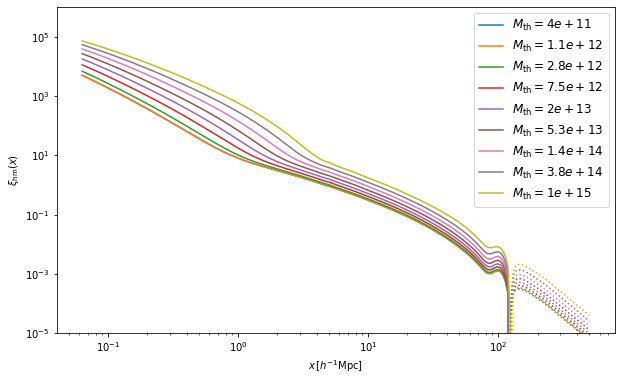

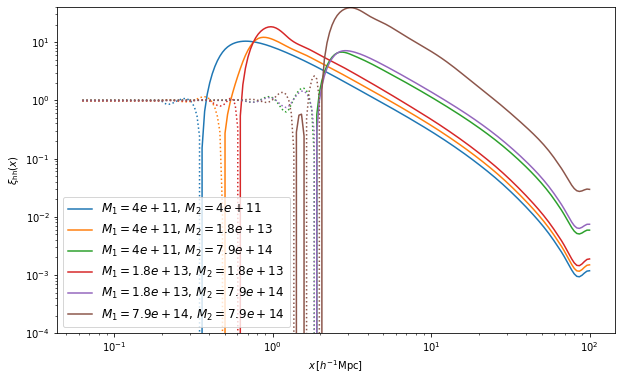

In [14]:
#cross halo simulation data from DarkEmu
rs = np.logspace(-1.2,2.7,200)

plt.figure(figsize=(10,6))
z = 0
for i, Mmin in enumerate(np.logspace(11.6,15,9)):
    xihm = emu.get_xicross_massthreshold(rs,Mmin,z)
    plt.loglog(rs,xihm,color="C{}".format(i),label='$M_\mathrm{th}=%0.2g$' %Mmin)
    plt.loglog(rs,-xihm,':',color="C{}".format(i))
plt.legend(fontsize=12)
plt.ylim(0.00001,1000000)
plt.xlabel("$x\,[h^{-1}\mathrm{Mpc}]$")
plt.ylabel("$\\xi_\mathrm{hm}(x)$")

#halo auto correlation from DarkEmu
rs = np.logspace(-1.2,2.0,200)
Ms = np.logspace(11.6,14.9,3)
plt.figure(figsize=(10,6))
ii = 0
for i in range(3):
    for j in range(i,3):
        xih = emu.get_xiauto_mass(rs,Ms[i],Ms[j],z)
        plt.loglog(rs,xih,color="C{}".format(ii),label='$M_1=%0.2g,\,M_2=%0.2g$' %(Ms[i],Ms[j]))
        plt.loglog(rs,-xih,':',color="C{}".format(ii))
        ii+=1
plt.legend(fontsize=12)
plt.ylim(0.0001,40)
plt.xlabel("$x\,[h^{-1}\mathrm{Mpc}]$")
plt.ylabel("$\\xi_\mathrm{hh}(x)$")


In [21]:
k_emu = 2*np.pi*np.logspace(np.log10(1.0/max(rs)), np.log10(1.0/min(rs)), len(rs)) 

halomod_data0 = np.loadtxt('THM_output_data/rVector_seljak.txt', skiprows=1, unpack=True)
r_hm0 = halomod_data0[0]
corr_hm_i0 = halomod_data0[6]
rhm_min = min(r_hm0)
rhm_max = max(r_hm0)
r_hm = np.linspace(rhm_min, rhm_max, len(rs))
corr_hm_i = np.interp(r_hm, r_hm0, corr_hm_i0)

halomod_data = np.loadtxt('THM_output_data/kVector_seljak.txt', skiprows=1, unpack=True)
k_hm0 = halomod_data[0]
pl_hm0 = halomod_data[1]
k_hm = np.linspace(1.0/max(r_hm), 1.0/min(r_hm), len(r_hm))
pl_hm = np.interp(k_hm, k_hm0, pl_hm0)
plin_hm = np.interp(k_emu, k_hm0, pl_hm0)


camb_data = np.loadtxt('linear_data.txt', unpack=True)
k_camb = camb_data[0]
pl_camb = camb_data[1]
pnl_camb = camb_data[2]
pl = np.interp(k_emu, k_camb, pl_camb)
pnl = np.interp(k_emu, k_camb, pnl_camb)


<ipython-input-22-a31e4fd4bb4d>:4: UserWarning: In hankel transform, power at r=1.59e-03 was extrapolated to k=1.26e+06. Maximum provided was 1.00e+02. 
  corr_camb_nl = power_to_corr_ogata(pnl_camb,k_camb,r_camb,h=0.005,
<ipython-input-22-a31e4fd4bb4d>:4: UserWarning: In hankel transform, power at r=2.51e+01 was extrapolated to k=9.82e-04. Minimum provided was 1.00e-03. Lowest value required is 1.55e-04
  corr_camb_nl = power_to_corr_ogata(pnl_camb,k_camb,r_camb,h=0.005,
<ipython-input-22-a31e4fd4bb4d>:9: UserWarning: In hankel transform, power at r=1.59e-03 was extrapolated to k=1.26e+06. Maximum provided was 1.00e+02. 
  corr_camb_lin = power_to_corr_ogata(pl_camb,k_camb,r_camb,h=0.005,
<ipython-input-22-a31e4fd4bb4d>:9: UserWarning: In hankel transform, power at r=2.51e+01 was extrapolated to k=9.82e-04. Minimum provided was 1.00e-03. Lowest value required is 1.55e-04
  corr_camb_lin = power_to_corr_ogata(pl_camb,k_camb,r_camb,h=0.005,
<ipython-input-22-a31e4fd4bb4d>:14: UserWarnin

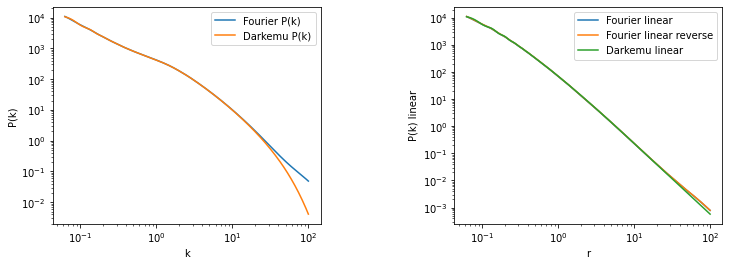

In [22]:
#testing Fourier transforms

r_camb = np.logspace(np.log10(1.0/max(k_camb)), np.log10(1.0/min(k_camb)), len(k_camb))/(2*np.pi)
corr_camb_nl = power_to_corr_ogata(pnl_camb,k_camb,r_camb,h=0.005,
                                           power_pos=(True,True),rtol=1e-3,atol=1e-15,_reverse=False)
corr_emu_nl = emu.get_xinl(rs, 0.0)
pknl_emu = emu.get_pknl(k_emu, 0.0)

corr_camb_lin = power_to_corr_ogata(pl_camb,k_camb,r_camb,h=0.005,
                                           power_pos=(True,True),rtol=1e-3,atol=1e-15,_reverse=False)
corr_emu_lin = emu.get_xilin(rs)
pklin_emu = emu.get_pklin(k_emu)

pnl_emu_check = ((2*np.pi)**3)*power_to_corr_ogata(corr_emu_nl,rs,k_emu,h=0.005,
                                           power_pos=(True,True),rtol=1e-5,atol=1e-15,_reverse=False)
pl_emu_check = ((2*np.pi)**3)*power_to_corr_ogata(corr_emu_lin,k_emu,rs,h=0.005,
                                           power_pos=(True,True),rtol=1e-5,atol=1e-15,_reverse=True)
pl_emu_check2 = ((2*np.pi)**3)*power_to_corr_ogata(corr_emu_lin,rs,k_emu,h=0.005,
                                           power_pos=(True,True),rtol=1e-5,atol=1e-15,_reverse=False)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(k_emu, pnl_emu_check, label='Fourier P(k)')
plt.plot(k_emu, pknl_emu, label='Darkemu P(k)')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(k_emu, pl_emu_check, label='Fourier linear')
plt.plot(k_emu, pl_emu_check2, label='Fourier linear reverse')
plt.plot(k_emu, pklin_emu, label='Darkemu linear')
plt.xlabel('r')
plt.ylabel('P(k) linear')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='best')
plt.subplots_adjust(wspace=0.5)
plt.show()


In [23]:
#declaring cosmological constants
sig_8 = 0.831
h = 0.68
H = 100*h
om_m = 0.3156
om_l = 1.0-om_m
rho_m = 8.76e10
rho_crit = rho_m/om_m
z = 128
dt_factor = z*((5.0*om_m/2.0)*(om_m**(4.0/7.0) - om_l + (1+0.5*om_m)*(1+om_l/H))**(-1))
overd = 200.0/om_m


In [24]:
all_m = np.array([np.logspace(12.0, 15.7, 1000)])
all_rvir = (3.0*all_m/(4.0*np.pi*rho_m*overd))**(1.0/3.0)
all_r = (3.0*all_m/(4.0*np.pi*rho_m))**(1.0/3.0)
all_m2 = 0.5*(all_m[:,1:] + all_m[:,:-1])
all_rvir2 = (3.0*all_m2/(4.0*np.pi*rho_m*overd))**(1.0/3.0)
all_r2 = (3.0*all_m2/(4.0*np.pi*rho_m))**(1.0/3.0)

df = sigma(f, 8.0)
norm = np.sqrt((sig_8**2)/df)

for i in range(1):
    all_sig = np.zeros(len(all_r[i]))
    for r_s in range(len(all_r[i])):
        all_sig[r_s] = norm*np.sqrt(sigma(f, all_r[i][r_s]))
    all_ln_sig = np.log(abs(all_sig)**(-1))
    
    all_sig2 = np.zeros(len(all_r2[i]))
    for r_s2 in range(len(all_r2[i])):
        all_sig2[r_s2] = norm*np.sqrt(sigma(f, all_r2[i][r_s2]))
    
    all_dm = np.diff(all_m[i])
    all_dln_sig = np.diff(all_ln_sig)/all_dm
    all_fsig = fSigma(all_sig2)
    print(len(all_fsig), len(all_dln_sig), len(all_m2))
    all_nm = rho_m*all_fsig*all_dln_sig/all_m2
    all_nhalo = np.sum(all_nm*all_dm)
    all_bf = bias(all_sig2, 1.686)
    
    ht = 2.0*np.arcsinh(np.sqrt(1.0/om_m - 1.0))/(3.0*np.sqrt(1.0-om_m))
    nu_all = (1.686/all_sig2)
    y_param_all = (0.42 + 0.2*nu_all**(-1.23) + 0.083*(nu_all**(-0.6)))/(ht**(2.0/3.0))
    c_all = 10.0**(0.78*np.log(y_param_all) + 1.09)
    all_rs = all_rvir2/c_all
    all_rho_s = (all_m2*(c_all**3.0))/(4.0*np.pi*(all_rvir2**3.0)*(np.log(c_all+1.0)-(c_all/(c_all+1.0))))
    
    n_halo_all = np.sum(all_nm*all_dm)
    

999 999 1


In [25]:
m12a = np.logspace(12.0, 12.6, 100)
m13a = np.logspace(13.0, 13.6, 100)
m14a = np.logspace(14.0, 14.6, 100)
m12b = np.logspace(12.6, 13.0, 100)
m13b = np.logspace(13.6, 14.0, 100)
m14b = np.logspace(14.6, 15.0, 100)
m15 = np.logspace(15.0, 15.6, 100)
m15x = np.logspace(15.0, 16.1, 100)
m_bins = np.array([m12a, m12b, m13a, m13b, m14a, m14b])

f_m, m_avg = mass_func(sigma, fSigma, m_bins, rho_m, overd)
p_hm, p_hh = make_matrix(m_avg, k_emu, rs, rho_m, f_m)
biases = p_hm[:,1]/pl[1]


<ipython-input-8-c5d86ff0ea1f>:14: UserWarning: In hankel transform, power at r=6.52e-02 was extrapolated to k=3.08e+04. Maximum provided was 1.00e+02. 
  hm_matrix[i] = 8*(np.pi**3)*power_to_corr_ogata(corr_hm_matrix[i], r, k,
<ipython-input-8-c5d86ff0ea1f>:14: UserWarning: In hankel transform, power at r=4.00e-01 was extrapolated to k=6.17e-02. Minimum provided was 6.31e-02. Lowest value required is 2.48e-04
  hm_matrix[i] = 8*(np.pi**3)*power_to_corr_ogata(corr_hm_matrix[i], r, k,
<ipython-input-8-c5d86ff0ea1f>:18: UserWarning: In hankel transform, power at r=6.52e-02 was extrapolated to k=3.08e+04. Maximum provided was 1.00e+02. 
  hh_matrix[i][j] = f_m[j]*8*(np.pi**3)*power_to_corr_ogata(corr_hh_matrix[i][j], r, k, h=0.005,
<ipython-input-8-c5d86ff0ea1f>:18: UserWarning: In hankel transform, power at r=4.00e-01 was extrapolated to k=6.17e-02. Minimum provided was 6.31e-02. Lowest value required is 2.48e-04
  hh_matrix[i][j] = f_m[j]*8*(np.pi**3)*power_to_corr_ogata(corr_hh_matrix[

In [26]:
matrix_i = p_hh
print(matrix_i[0][0][0], matrix_i[1][0][0], matrix_i[2][0][0], matrix_i[3][0][0])
matrix_f = matrix_i.T
matrix_inv = inv(matrix_f).T

u = u_matrix(matrix_inv, p_hm, biases, pl)
print(u.shape)
umatrix_12a = u[0]
umatrix_12b = u[1]
umatrix_13a = u[2]
umatrix_13b = u[3]
umatrix_14a = u[4]
umatrix_14b = u[5]


446.3722420793267 503.1210688092175 642.6124051819135 854.3906673003339
(6, 200)


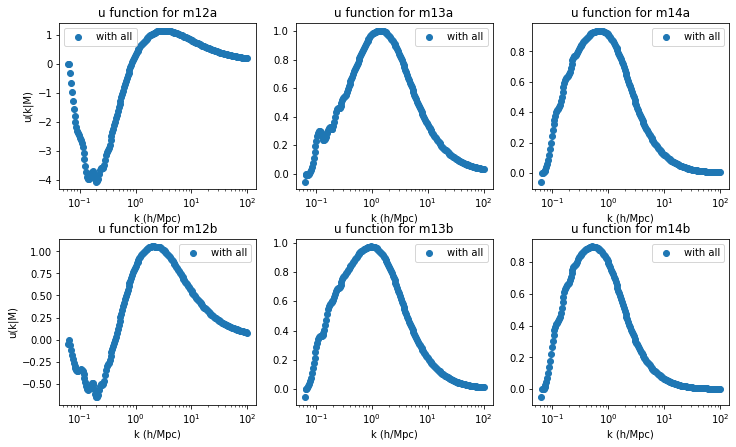

In [27]:
plt.figure(figsize=(12,11))
plt.subplot(331)
plt.scatter(k_emu, umatrix_12a, label='with all')
plt.ylabel('u(k|M)')
plt.xlabel('k (h/Mpc)')
plt.xscale('log')
plt.legend(loc='best')
plt.title('u function for m12a')

plt.subplot(332)
plt.scatter(k_emu, umatrix_13a, label='with all')
plt.xlabel('k (h/Mpc)')
plt.xscale('log')
plt.legend(loc='best')
plt.title('u function for m13a')

plt.subplot(333)
plt.scatter(k_emu, umatrix_14a, label='with all')
plt.xlabel('k (h/Mpc)')
plt.xscale('log')
plt.legend(loc='best')
plt.title('u function for m14a')

plt.subplot(334)
plt.scatter(k_emu, umatrix_12b, label='with all')
plt.ylabel('u(k|M)')
plt.xlabel('k (h/Mpc)')
plt.xscale('log')
plt.legend(loc='best')
plt.title('u function for m12b')

plt.subplot(335)
plt.scatter(k_emu, umatrix_13b, label='with all')
plt.xlabel('k (h/Mpc)')
plt.xscale('log')
plt.legend(loc='best')
plt.title('u function for m13b')

plt.subplot(336)
plt.scatter(k_emu, umatrix_14b, label='with all')
plt.xlabel('k (h/Mpc)')
plt.xscale('log')
plt.legend(loc='best')
plt.title('u function for m14b')

plt.subplots_adjust(wspace=0.2, hspace=0.3)


In [28]:
p12a_matrix = power_matrix(p_hh[0], u)
p12b_matrix = power_matrix(p_hh[1], u)
p13a_matrix = power_matrix(p_hh[2], u)
p13b_matrix = power_matrix(p_hh[3], u)
p14a_matrix = power_matrix(p_hh[4], u)
p14b_matrix = power_matrix(p_hh[5], u)

phm_recons_12a = p12a_matrix + biases[0]*pl
phm_recons_13a = p13a_matrix + biases[2]*pl
phm_recons_14a = p14a_matrix + biases[4]*pl
phm_recons_12b = p12b_matrix + biases[1]*pl
phm_recons_13b = p13b_matrix + biases[3]*pl
phm_recons_14b = p14b_matrix + biases[5]*pl


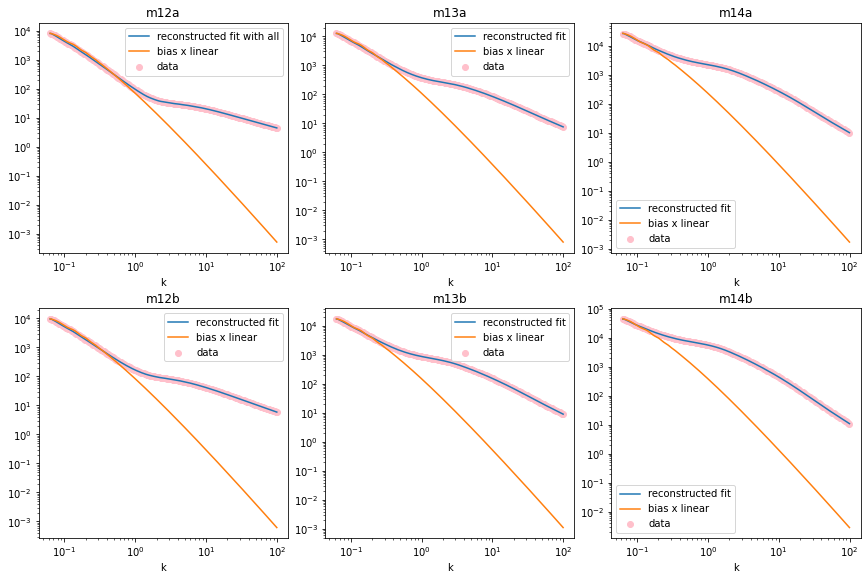

In [29]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.scatter(k_emu, p_hm[0], label='data', c='pink')
plt.plot(k_emu, phm_recons_12a, label='reconstructed fit with all')
plt.plot(k_emu, biases[0]*pl, label='bias x linear')
plt.xlabel('k')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1.0e-3, 1.0])
plt.title('m12a')
plt.legend(loc='best')

plt.subplot(232)
plt.scatter(k_emu, p_hm[2], label='data', c='pink')
plt.plot(k_emu, phm_recons_13a, label='reconstructed fit')
plt.plot(k_emu, biases[2]*pl, label='bias x linear')
plt.xlabel('k')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1.0e-3, 1.0])
plt.title('m13a')
plt.legend(loc='best')

plt.subplot(233)
plt.scatter(k_emu, p_hm[4], label='data', c='pink')
plt.plot(k_emu, phm_recons_14a, label='reconstructed fit')
plt.plot(k_emu, biases[4]*pl, label='bias x linear')
plt.xlabel('k')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1.0e-3, 1.0])
plt.title('m14a')
plt.legend(loc='best')

plt.subplot(234)
plt.scatter(k_emu, p_hm[1], label='data', c='pink')
plt.plot(k_emu, phm_recons_12b, label='reconstructed fit')
plt.plot(k_emu, biases[1]*pl, label='bias x linear')
plt.xlabel('k')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1.0e-3, 1.0])
plt.title('m12b')
plt.legend(loc='best')

plt.subplot(235)
plt.scatter(k_emu, p_hm[3], label='data', c='pink')
plt.plot(k_emu, phm_recons_13b, label='reconstructed fit')
plt.plot(k_emu, biases[3]*pl, label='bias x linear')
plt.xlabel('k')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1.0e-3, 1.0])
plt.title('m13b')
plt.legend(loc='best')

plt.subplot(236)
plt.scatter(k_emu, p_hm[5], label='data', c='pink')
plt.plot(k_emu, phm_recons_14b, label='reconstructed fit')
plt.plot(k_emu, biases[5]*pl, label='bias x linear')
plt.xlabel('k')
plt.xscale('log')
plt.yscale('log')
plt.title('m14b')
plt.legend(loc='best')

plt.tight_layout(pad=0.5)


In [30]:
u12a_fourier = power_to_corr_ogata(umatrix_12a,k_emu,rs,h=0.005,power_pos=(True,True),
                                   rtol=1e-3,atol=1e-15,_reverse=False)
u13a_fourier = power_to_corr_ogata(umatrix_13a,k_emu,rs,h=0.005,power_pos=(True,True),
                                   rtol=1e-3,atol=1e-15,_reverse=False)
u14a_fourier = power_to_corr_ogata(umatrix_14a,k_emu,rs,h=0.005,power_pos=(True,True),
                                   rtol=1e-3,atol=1e-15,_reverse=False)

u12b_fourier = power_to_corr_ogata(umatrix_12b,k_emu,rs,h=0.005,power_pos=(True,True),
                                   rtol=1e-3,atol=1e-15,_reverse=False)
u13b_fourier = power_to_corr_ogata(umatrix_13b,k_emu,rs,h=0.005,power_pos=(True,True),
                                   rtol=1e-3,atol=1e-15,_reverse=False)
u14b_fourier = power_to_corr_ogata(umatrix_14b,k_emu,rs,h=0.005,power_pos=(True,True),
                                   rtol=1e-3,atol=1e-15,_reverse=False)


<ipython-input-30-86672f6a5458>:1: UserWarning: In hankel transform, power at r=6.31e-02 was extrapolated to k=3.19e+04. Maximum provided was 9.96e+01. 
  u12a_fourier = power_to_corr_ogata(umatrix_12a,k_emu,rs,h=0.005,power_pos=(True,True),
<ipython-input-30-86672f6a5458>:1: UserWarning: In hankel transform, power at r=4.02e-01 was extrapolated to k=6.14e-02. Minimum provided was 6.28e-02. Lowest value required is 2.47e-04
  u12a_fourier = power_to_corr_ogata(umatrix_12a,k_emu,rs,h=0.005,power_pos=(True,True),
<ipython-input-30-86672f6a5458>:3: UserWarning: In hankel transform, power at r=6.31e-02 was extrapolated to k=3.19e+04. Maximum provided was 9.96e+01. 
  u13a_fourier = power_to_corr_ogata(umatrix_13a,k_emu,rs,h=0.005,power_pos=(True,True),
<ipython-input-30-86672f6a5458>:3: UserWarning: In hankel transform, power at r=4.02e-01 was extrapolated to k=6.14e-02. Minimum provided was 6.28e-02. Lowest value required is 2.47e-04
  u13a_fourier = power_to_corr_ogata(umatrix_13a,k_emu,

In [31]:
rs2 = 0.5*(rs[1:]+rs[:-1])
dr = np.diff(rs)

u12a_fourier_avg = 0.5*(u12a_fourier[1:]+u12a_fourier[:-1])
A_12a = 4*np.pi*np.sum((rs2**2)*u12a_fourier_avg*dr)/(2*np.pi*max(rs)**2)
u_comp_12a = u12a_fourier - A_12a/rs

u13a_fourier_avg = 0.5*(u13a_fourier[1:]+u13a_fourier[:-1])
A_13a = 4*np.pi*np.sum((rs2**2)*u13a_fourier_avg*dr)/(2*np.pi*max(rs)**2)
u_comp_13a = u13a_fourier - A_13a/rs

u14a_fourier_avg = 0.5*(u14a_fourier[1:]+u14a_fourier[:-1])
A_14a = 4*np.pi*np.sum((rs2**2)*u14a_fourier_avg*dr)/(2*np.pi*max(rs)**2)
u_comp_14a = u14a_fourier - A_14a/rs

u12b_fourier_avg = 0.5*(u12b_fourier[1:]+u12b_fourier[:-1])
A_12b = 4*np.pi*np.sum((rs2**2)*u12b_fourier_avg*dr)/(2*np.pi*max(rs)**2)
u_comp_12b = u12b_fourier - A_12b/rs

u13b_fourier_avg = 0.5*(u13b_fourier[1:]+u13b_fourier[:-1])
A_13b = 4*np.pi*np.sum((rs2**2)*u13b_fourier_avg*dr)/(2*np.pi*max(rs)**2)
u_comp_13b = u13b_fourier - A_13b/rs

u14b_fourier_avg = 0.5*(u14b_fourier[1:]+u14b_fourier[:-1])
A_14b = 4*np.pi*np.sum((rs2**2)*u14b_fourier_avg*dr)/(2*np.pi*max(rs)**2)
u_comp_14b = u14b_fourier - A_14b/rs


In [32]:
c_m12a, rs_m12a, rho_sc_m12a = scale_quant(f, sigma, m_avg[0], overd, rho_m, om_m, norm, ht)
c_m13a, rs_m13a, rho_sc_m13a = scale_quant(f, sigma, m_avg[2], overd, rho_m, om_m, norm, ht)
c_m14a, rs_m14a, rho_sc_m14a = scale_quant(f, sigma, m_avg[4], overd, rho_m, om_m, norm, ht)
c_m12b, rs_m12b, rho_sc_m12b = scale_quant(f, sigma, m_avg[1], overd, rho_m, om_m, norm, ht)
c_m13b, rs_m13b, rho_sc_m13b = scale_quant(f, sigma, m_avg[3], overd, rho_m, om_m, norm, ht)
c_m14b, rs_m14b, rho_sc_m14b = scale_quant(f, sigma, m_avg[5], overd, rho_m, om_m, norm, ht)

uNFW_12a = u_NFW(k_emu, rs_m12a, rho_sc_m12a, m_avg[0], c_m12a)
uNFW_13a = u_NFW(k_emu, rs_m13a, rho_sc_m13a, m_avg[2], c_m13a)
uNFW_14a = u_NFW(k_emu, rs_m14a, rho_sc_m14a, m_avg[4], c_m14a)
uNFW_12b = u_NFW(k_emu, rs_m12b, rho_sc_m12b, m_avg[1], c_m12b)
uNFW_13b = u_NFW(k_emu, rs_m13b, rho_sc_m13b, m_avg[3], c_m13b)
uNFW_14b = u_NFW(k_emu, rs_m14b, rho_sc_m14b, m_avg[5], c_m14b)


In [33]:
u_nfw_avg12a = nfw_avg(sigma, fSigma, m12a, rho_m, overd, k_emu)
u_nfw_avg12b = nfw_avg(sigma, fSigma, m12b, rho_m, overd, k_emu)
u_nfw_avg13a = nfw_avg(sigma, fSigma, m13a, rho_m, overd, k_emu)
u_nfw_avg13b = nfw_avg(sigma, fSigma, m13b, rho_m, overd, k_emu)
u_nfw_avg14a = nfw_avg(sigma, fSigma, m14a, rho_m, overd, k_emu)
u_nfw_avg14b = nfw_avg(sigma, fSigma, m14b, rho_m, overd, k_emu)

rho_NFW_12a = nfw(rho_crit, rs, rs_m12a, c_m12a)/m_avg[0]
rho_NFW_13a = nfw(rho_crit, rs, rs_m13a, c_m13a)/m_avg[2]
rho_NFW_14a = nfw(rho_crit, rs, rs_m14a, c_m14a)/m_avg[4]
rho_NFW_12b = nfw(rho_crit, rs, rs_m12b, c_m12b)/m_avg[1]
rho_NFW_13b = nfw(rho_crit, rs, rs_m13b, c_m13b)/m_avg[3]
rho_NFW_14b = nfw(rho_crit, rs, rs_m14b, c_m14b)/m_avg[5]


In [34]:
r_splashback_12a = 0.81*(1.0 + 0.97*np.exp(-nu_all/2.44))*np.mean(rs_m12a*c_m12a)
r_splashback_12b = 0.81*(1.0 + 0.97*np.exp(-nu_all/2.44))*np.mean(rs_m12b*c_m12b)
r_splashback_13a = 0.81*(1.0 + 0.97*np.exp(-nu_all/2.44))*np.mean(rs_m13a*c_m13a)
r_splashback_13b = 0.81*(1.0 + 0.97*np.exp(-nu_all/2.44))*np.mean(rs_m13b*c_m13b)
r_splashback_14a = 0.81*(1.0 + 0.97*np.exp(-nu_all/2.44))*np.mean(rs_m14a*c_m14a)
r_splashback_14b = 0.81*(1.0 + 0.97*np.exp(-nu_all/2.44))*np.mean(rs_m14b*c_m14b)


In [35]:
rvir12a = rs/(rs_m12a)
rvir12b = rs/(rs_m12b)
rvir13a = rs/(rs_m13a)
rvir13b = rs/(rs_m13b)
rvir14a = rs/(rs_m14a)
rvir14b = rs/(rs_m14b)

params_12a0, pcov12a0 = curve_fit(fit_u, (rvir12a)[:70], (u12a_fourier/rho_NFW_12a)[:70], p0=(1.0e-8,0.75))
u12a_fit0 = rho_NFW_12a*fit_u((rvir12a), params_12a0[0], params_12a0[1])

params_13a0, pcov13a0 = curve_fit(fit_u, (rvir13a)[:80],(u13a_fourier/rho_NFW_13a)[:80], p0=(1.0e-8,0.75)) 
u13a_fit0 = rho_NFW_13a*fit_u((rvir13a), params_13a0[0], params_13a0[1])

params_14a0, pcov14a0 = curve_fit(fit_u, (rvir14a)[:97], (u14a_fourier/rho_NFW_14a)[:97], p0=(1.0e-8,0.75))
u14a_fit0 = rho_NFW_14a*fit_u((rvir14a), params_14a0[0], params_14a0[1])

params_12b0, pcov12b0 = curve_fit(fit_u, (rvir12b)[:75],(u12b_fourier/rho_NFW_12b)[:75], p0=(1.0e-8,0.75)) 
u12b_fit0 = rho_NFW_12b*fit_u((rvir12b), params_12b0[0], params_12b0[1])

params_13b0, pcov13b0 = curve_fit(fit_u, (rvir13b)[:90],(u13b_fourier/rho_NFW_13b)[:90])
u13b_fit0 = rho_NFW_13b*fit_u((rvir13b), params_13b0[0], params_13b0[1])

params_14b0, pcov14b0 = curve_fit(fit_u, (rvir14b)[:102],(u14b_fourier/rho_NFW_14b)[:102])
u14b_fit0 = rho_NFW_14b*fit_u((rvir14b), params_14b0[0], params_14b0[1])


<ipython-input-12-6b7e02fa98ff>:3: RuntimeWarning: invalid value encountered in sqrt
  y1 = np.sqrt(b)*(-4*(1+b) + (b**0.25)*(2*np.sqrt(2)-3*(b**0.25)+4*np.sqrt(2*b)-2*np.sqrt(2)*b+b**1.25)*np.pi + np.log(b)*(-1+3*b))
<ipython-input-12-6b7e02fa98ff>:3: RuntimeWarning: invalid value encountered in double_scalars
  y1 = np.sqrt(b)*(-4*(1+b) + (b**0.25)*(2*np.sqrt(2)-3*(b**0.25)+4*np.sqrt(2*b)-2*np.sqrt(2)*b+b**1.25)*np.pi + np.log(b)*(-1+3*b))
<ipython-input-12-6b7e02fa98ff>:3: RuntimeWarning: invalid value encountered in log
  y1 = np.sqrt(b)*(-4*(1+b) + (b**0.25)*(2*np.sqrt(2)-3*(b**0.25)+4*np.sqrt(2*b)-2*np.sqrt(2)*b+b**1.25)*np.pi + np.log(b)*(-1+3*b))
<ipython-input-12-6b7e02fa98ff>:4: RuntimeWarning: invalid value encountered in double_scalars
  y2 = np.pi*(1-2*np.sqrt(2)*(b**0.25) + 4*np.sqrt(2)*(b**0.75) - 3*b + 2*np.sqrt(2)*(b**1.25)) + np.sqrt(b)*(-4*(1+b)+np.log(b)*(-3+b))
<ipython-input-12-6b7e02fa98ff>:4: RuntimeWarning: invalid value encountered in sqrt
  y2 = np.pi*(1-2*np

In [36]:
params_12a = mcmc_MH(lnprob, rvir12a[:70], (u12a_fourier/rho_NFW_12a)[:70], params_12a0, fit_u)[0]
u12a_fit = rho_NFW_12a*fit_u(rvir12a, params_12a[0], params_12a[1])

params_13a = mcmc_MH(lnprob, rvir13a[:95], (u13a_fourier/rho_NFW_13a)[:95], params_13a0, fit_u)[0]
u13a_fit = rho_NFW_13a*fit_u(rvir13a, params_13a[0], params_13a[1])

params_14a = mcmc_MH(lnprob, rvir14a[:100], (u14a_fourier/rho_NFW_14a)[:100], params_14a0, fit_u)[0]
u14a_fit = rho_NFW_14a*fit_u(rvir14a, params_14a[0], params_14a[1])

params_12b = mcmc_MH(lnprob, rvir12b[:90], (u12b_fourier/rho_NFW_12b)[:90], params_12b0, fit_u)[0]
u12b_fit = rho_NFW_12b*fit_u(rvir12b, params_12b[0], params_12b[1])

params_13b = mcmc_MH(lnprob, rvir13b[:100], (u13b_fourier/rho_NFW_13b)[:100], params_13b0, fit_u)[0]
u13b_fit = rho_NFW_13b*fit_u(rvir13b, params_13b[0], params_13b[1])

params_14b = mcmc_MH(lnprob, rvir14b[:105], (u14b_fourier/rho_NFW_14b)[:105], params_14b0, fit_u)[0]
u14b_fit = rho_NFW_14b*fit_u(rvir14b, params_14b[0], params_14b[1])


<ipython-input-12-6b7e02fa98ff>:3: RuntimeWarning: invalid value encountered in sqrt
  y1 = np.sqrt(b)*(-4*(1+b) + (b**0.25)*(2*np.sqrt(2)-3*(b**0.25)+4*np.sqrt(2*b)-2*np.sqrt(2)*b+b**1.25)*np.pi + np.log(b)*(-1+3*b))
<ipython-input-12-6b7e02fa98ff>:3: RuntimeWarning: invalid value encountered in double_scalars
  y1 = np.sqrt(b)*(-4*(1+b) + (b**0.25)*(2*np.sqrt(2)-3*(b**0.25)+4*np.sqrt(2*b)-2*np.sqrt(2)*b+b**1.25)*np.pi + np.log(b)*(-1+3*b))
<ipython-input-12-6b7e02fa98ff>:3: RuntimeWarning: invalid value encountered in log
  y1 = np.sqrt(b)*(-4*(1+b) + (b**0.25)*(2*np.sqrt(2)-3*(b**0.25)+4*np.sqrt(2*b)-2*np.sqrt(2)*b+b**1.25)*np.pi + np.log(b)*(-1+3*b))
<ipython-input-12-6b7e02fa98ff>:4: RuntimeWarning: invalid value encountered in double_scalars
  y2 = np.pi*(1-2*np.sqrt(2)*(b**0.25) + 4*np.sqrt(2)*(b**0.75) - 3*b + 2*np.sqrt(2)*(b**1.25)) + np.sqrt(b)*(-4*(1+b)+np.log(b)*(-3+b))
<ipython-input-12-6b7e02fa98ff>:4: RuntimeWarning: invalid value encountered in sqrt
  y2 = np.pi*(1-2*np

In [37]:
params_min_12a = leastsq(fit_min, params_12a0, args=((rvir12a)[:75], (u12a_fourier/rho_NFW_12a)[:75]))[0]
u12a_fit2 = rho_NFW_12a*fit_u((rs/rs_m12a), params_min_12a[0], params_min_12a[1])

params_min_13a = leastsq(fit_min, params_13a0, args=((rvir13a)[:80], (u_comp_13a/rho_NFW_13a)[:80]))[0]
u13a_fit2 = rho_NFW_13a*fit_u((rs/rs_m13a), params_min_13a[0], params_min_13a[1])

params_min_14a = leastsq(fit_min, params_14a0, args=((rvir14a)[:100], (u_comp_14a/rho_NFW_14a)[:100]))[0]
u14a_fit2 = rho_NFW_14a*fit_u((rs/rs_m14a), params_min_14a[0], params_min_14a[1])

params_min_12b = leastsq(fit_min, params_12b0, args=((rvir12b)[:75], (u_comp_12b/rho_NFW_12b)[:75]))[0]
u12b_fit2 = rho_NFW_12b*fit_u((rs/rs_m12b), params_min_12b[0], params_min_12b[1])

params_min_13b = leastsq(fit_min, params_13b0, args=((rvir13b)[:95], (u_comp_13b/rho_NFW_13b)[:95]))[0]
u13b_fit2 = rho_NFW_13b*fit_u((rs/rs_m13b), params_min_13b[0], params_min_13b[1])

params_min_14b = leastsq(fit_min, params_14b0, args=((rvir14b)[:110], (u_comp_14b/rho_NFW_14b)[:110]))[0]
u14b_fit2 = rho_NFW_14b*fit_u((rs/rs_m14b), params_min_14b[0], params_min_14b[1])


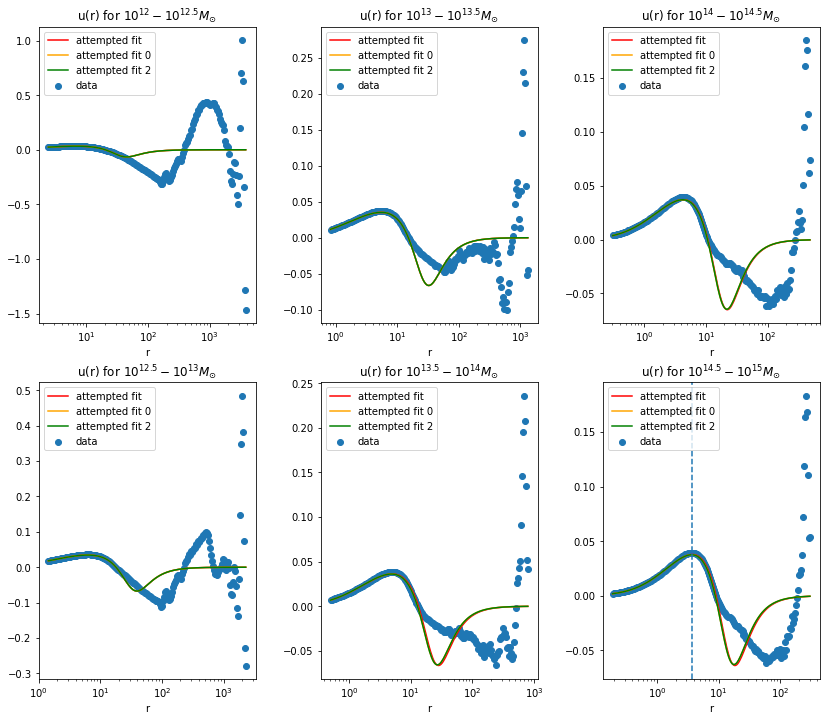

In [39]:
n2=3

plt.figure(figsize=(14,12))
plt.subplot(231)
plt.scatter(rvir12a, u_comp_12a*(rs**n2), label='data')
plt.plot(rvir12a, u12a_fit2*(rs**n2), label='attempted fit', c='red')
plt.plot(rvir12a, u12a_fit0*(rs**n2), label='attempted fit 0', c='orange')
plt.plot(rvir12a, u12a_fit*(rs**n2), label='attempted fit 2', c='green')
plt.xlabel('r')
plt.xscale('log')
plt.legend(loc='best')
plt.title(r'u(r) for $10^{12}-10^{12.5}M_{\odot}$')

plt.subplot(232)
plt.scatter(rvir13a, u_comp_13a*(rs**n2), label='data')
plt.plot(rvir13a, u13a_fit2*(rs**n2), label='attempted fit', c='red')
plt.plot(rvir13a, u13a_fit0*(rs**n2), label='attempted fit 0', c='orange')
plt.plot(rvir13a, u13a_fit*(rs**n2), label='attempted fit 2', c='green')
plt.xlabel('r')
plt.xscale('log')
plt.legend(loc='best')
plt.title(r'u(r) for $10^{13}-10^{13.5}M_{\odot}$')

plt.subplot(233)
plt.scatter(rvir14a, u_comp_14a*(rs**n2), label='data')
plt.plot(rvir14a, u14a_fit2*(rs**n2), label='attempted fit', c='red')
plt.plot(rvir14a, u14a_fit0*(rs**n2), label='attempted fit 0', c='orange')
plt.plot(rvir14a, u14a_fit*(rs**n2), label='attempted fit 2', c='green')
plt.xlabel('r')
plt.xscale('log')
plt.legend(loc='best')
plt.title(r'u(r) for $10^{14}-10^{14.5}M_{\odot}$')

plt.subplot(234)
plt.scatter(rvir12b, u_comp_12b*(rs**n2), label='data')
plt.plot(rvir12b, u12b_fit2*(rs**n2), label='attempted fit', c='red')
plt.plot(rvir12b, u12b_fit0*(rs**n2), label='attempted fit 0', c='orange')
plt.plot(rvir12b, u12b_fit*(rs**n2), label='attempted fit 2', c='green')
plt.xlabel('r')
plt.xscale('log')
plt.legend(loc='best')
plt.title(r'u(r) for $10^{12.5}-10^{13}M_{\odot}$')

plt.subplot(235)
plt.scatter(rvir13b, u_comp_13b*(rs**n2), label='data')
plt.plot(rvir13b, u13b_fit2*(rs**n2), label='attempted fit', c='red')
plt.plot(rvir13b, u13b_fit0*(rs**n2), label='attempted fit 0', c='orange')
plt.plot(rvir13b, u13b_fit*(rs**n2), label='attempted fit 2', c='green')
plt.xlabel('r')
plt.xscale('log')
plt.legend(loc='best')
plt.title(r'u(r) for $10^{13.5}-10^{14}M_{\odot}$')

plt.subplot(236)
plt.scatter(rvir14b, u_comp_14b*(rs**n2), label='data')
plt.plot(rvir14b, u14b_fit2*(rs**n2), label='attempted fit', c='red')
plt.plot(rvir14b, u14b_fit0*(rs**n2), label='attempted fit 0', c='orange')
plt.plot(rvir14b, u14b_fit*(rs**n2), label='attempted fit 2', c='green')
plt.axvline(x=rs[110], linestyle='--')
plt.xlabel('r')
plt.xscale('log')
plt.legend(loc='best')
plt.title(r'u(r) for $10^{14.5}-10^{15}M_{\odot}$')

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.2)


In [40]:
#zero-crossing radius

def r_zerocross(b):
    y1 = np.sqrt(b)*(-4*(1+b) + (b**0.25)*(2*np.sqrt(2)-3*(b**0.25)+4*np.sqrt(2*b)-2*np.sqrt(2)*b+b**1.25)*np.pi + np.log(b)*(-1+3*b))
    y2 = np.pi*(1-2*np.sqrt(2)*(b**0.25) + 4*np.sqrt(2)*(b**0.75) - 3*b + 2*np.sqrt(2)*(b**1.25)) + np.sqrt(b)*(-4*(1+b)+np.log(b)*(-3+b))
    r_zc = np.sqrt(y2/y1)    
    return r_zc

r_zc_12a = r_zerocross(params_min_12a[0])*rs_m12a
r_zc_12b = r_zerocross(params_min_12b[0])*rs_m12b
r_zc_13a = r_zerocross(params_min_13a[0])*rs_m13a
r_zc_13b = r_zerocross(params_min_13b[0])*rs_m13b
r_zc_14a = r_zerocross(params_min_14a[0])*rs_m14a
r_zc_14b = r_zerocross(params_min_14b[0])*rs_m14b

r_z_frac_12a = r_zc_12a/(c_m12a*rs_m12a)
r_z_frac_12b = r_zc_12b/(c_m12b*rs_m12b)
r_z_frac_13a = r_zc_13a/(c_m13a*rs_m13a)
r_z_frac_13b = r_zc_13b/(c_m13b*rs_m13b)
r_z_frac_14a = r_zc_14a/(c_m14a*rs_m14a)
r_z_frac_14b = r_zc_14b/(c_m14b*rs_m14b)

print(r_zc_12a, r_z_frac_12a)
print(r_zc_12b, r_z_frac_12b)
print(r_zc_13a, r_z_frac_13a)
print(r_zc_13b, r_z_frac_13b)
print(r_zc_14a, r_z_frac_14a)
print(r_zc_14b, r_z_frac_14b)


0.5285833802431082 2.504371330051835
0.7868330518524301 2.584611914709434
1.1531010546609277 2.5508775679543345
1.6838221266626623 2.584248327229298
2.216866259845319 2.358414296261877
3.0028917311951133 2.2197196977721316


In [41]:
uk_12a = (8*np.pi**3)*power_to_corr_ogata(u12a_fit2, rs, k_emu, h=0.001, 
                                        power_pos=(True,True), rtol=1e-3,atol=1e-15,_reverse=False)
uk_12b = (8*np.pi**3)*power_to_corr_ogata(u12b_fit2, rs, k_emu, h=0.001,
                                            power_pos=(True,True), rtol=1e-3,atol=1e-15,_reverse=False)
uk_13a = (8*np.pi**3)*power_to_corr_ogata(u13a_fit2, rs, k_emu, h=0.001,
                                            power_pos=(True,True), rtol=1e-3,atol=1e-15,_reverse=False)
uk_13b = (8*np.pi**3)*power_to_corr_ogata(u13b_fit2, rs, k_emu, h=0.001,
                                            power_pos=(True,True), rtol=1e-3,atol=1e-15,_reverse=False)
uk_14a = (8*np.pi**3)*power_to_corr_ogata(u14a_fit2, rs, k_emu, h=0.001,
                                            power_pos=(True,True), rtol=1e-3,atol=1e-15,_reverse=False)
uk_14b = (8*np.pi**3)*power_to_corr_ogata(u14b_fit2, rs, k_emu, h=0.001,
                                            power_pos=(True,True), rtol=1e-3,atol=1e-15,_reverse=False)


<ipython-input-41-25ca4707f800>:1: UserWarning: In hankel transform, power at r=7.85e-02 was extrapolated to k=6.29e-02. Minimum provided was 6.31e-02. Lowest value required is 4.96e-05
  uk_12a = (8*np.pi**3)*power_to_corr_ogata(u12a_fit2, rs, k_emu, h=0.001,
<ipython-input-41-25ca4707f800>:1: UserWarning: In hankel transform, power at r=8.45e-02 was extrapolated to k=1.19e+05. Maximum provided was 1.00e+02. 
  uk_12a = (8*np.pi**3)*power_to_corr_ogata(u12a_fit2, rs, k_emu, h=0.001,
<ipython-input-41-25ca4707f800>:3: UserWarning: In hankel transform, power at r=7.85e-02 was extrapolated to k=6.29e-02. Minimum provided was 6.31e-02. Lowest value required is 4.96e-05
  uk_12b = (8*np.pi**3)*power_to_corr_ogata(u12b_fit2, rs, k_emu, h=0.001,
<ipython-input-41-25ca4707f800>:5: UserWarning: In hankel transform, power at r=7.85e-02 was extrapolated to k=6.29e-02. Minimum provided was 6.31e-02. Lowest value required is 4.96e-05
  uk_13a = (8*np.pi**3)*power_to_corr_ogata(u13a_fit2, rs, k_emu

In [42]:
u_all_mod = np.array([uk_12a, uk_12b, uk_13a, uk_13b, uk_14a, uk_14b])

p12a_matrix_th = power_matrix(p_hh[0], u_all_mod)
p12b_matrix_th = power_matrix(p_hh[1], u_all_mod)
p13a_matrix_th = power_matrix(p_hh[2], u_all_mod)
p13b_matrix_th = power_matrix(p_hh[3], u_all_mod)
p14a_matrix_th = power_matrix(p_hh[4], u_all_mod)
p14b_matrix_th = power_matrix(p_hh[5], u_all_mod)

phm_recons_12a_th = p12a_matrix_th + biases[0]*pl
phm_recons_13a_th = p13a_matrix_th + biases[2]*pl
phm_recons_14a_th = p14a_matrix_th + biases[4]*pl
phm_recons_12b_th = p12b_matrix_th + biases[1]*pl
phm_recons_13b_th = p13b_matrix_th + biases[3]*pl
phm_recons_14b_th = p14b_matrix_th + biases[5]*pl


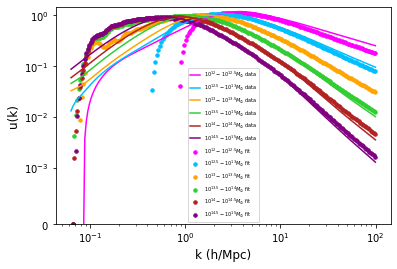

In [43]:
plt.figure()
plt.plot(k_emu, uk_12a, label=r'$10^{12}-10^{12.5}M_{\odot}$ data', c='magenta')
plt.scatter(k_emu, umatrix_12a, label=r'$10^{12}-10^{12.5}M_{\odot}$ fit', c='magenta', s=12)
plt.plot(k_emu, uk_12b, label=r'$10^{12.5}-10^{13}M_{\odot}$ data', c='deepskyblue')
plt.scatter(k_emu, umatrix_12b, label=r'$10^{12.5}-10^{13}M_{\odot}$ fit', c='deepskyblue', s=12)
plt.plot(k_emu, uk_13a, label=r'$10^{13}-10^{13.5}M_{\odot}$ data', c='orange')
plt.scatter(k_emu, umatrix_13a, label=r'$10^{13}-10^{13.5}M_{\odot}$ fit', c='orange', s=12)
plt.plot(k_emu, uk_13b, label=r'$10^{13.5}-10^{15}M_{\odot}$ data', c='limegreen')
plt.scatter(k_emu, umatrix_13b, label=r'$10^{13.5}-10^{14}M_{\odot}$ fit', c='limegreen', s=12)
plt.plot(k_emu, uk_14a, label=r'$10^{14}-10^{14.5}M_{\odot}$ data', c='firebrick')
plt.scatter(k_emu, umatrix_14a, label=r'$10^{14}-10^{14.5}M_{\odot}$ fit', c='firebrick', s=12)
plt.plot(k_emu, uk_14b, label=r'$10^{14.5}-10^{15}M_{\odot}$ data', c='purple')
plt.scatter(k_emu, umatrix_14b, label=r'$10^{14.5}-10^{15}M_{\odot}$ fit', c='purple', s=12)
plt.xlabel('k (h/Mpc)', fontsize=12)
plt.ylabel('u(k)', fontsize=12)
plt.xscale('log')
plt.yscale('symlog', linthresh=1.0e-3)
plt.ylim([0.0,1.5])
plt.legend(loc='lower center', prop={'size':5})
plt.show()

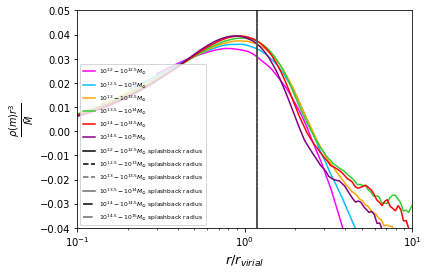

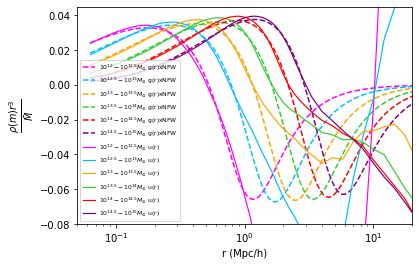

In [50]:
n2 = 3

r_rebin_c12b = (rs/(c_m12b*rs_m12b))
r_rebin_c13b = (rs/(c_m13b*rs_m13b))
r_rebin_c14b = (rs/(c_m14b*rs_m14b))
r_rebin_c12a = (rs/(c_m12a*rs_m12a))
r_rebin_c13a = (rs/(c_m13a*rs_m13a))
r_rebin_c14a = (rs/(c_m14a*rs_m14a))

r_rebin = np.append(rs[:100], np.mean(rs[100:].reshape(-1, 5), axis=1))
rebin_12a = np.append(u12a_fourier[:100], np.mean(u12a_fourier[100:].reshape(-1, 5), axis=1))
rebin_13a = np.append(u13a_fourier[:100], np.mean(u13a_fourier[100:].reshape(-1, 5), axis=1))
rebin_14a = np.append(u14a_fourier[:100], np.mean(u14a_fourier[100:].reshape(-1, 5), axis=1))
rebin_12b = np.append(u12b_fourier[:100], np.mean(u12b_fourier[100:].reshape(-1, 5), axis=1))
rebin_13b = np.append(u13b_fourier[:100], np.mean(u13b_fourier[100:].reshape(-1, 5), axis=1))
rebin_14b = np.append(u14b_fourier[:100], np.mean(u14b_fourier[100:].reshape(-1, 5), axis=1))

plt.figure(figsize=(6,4))
plt.plot(r_rebin_c12a, u12a_fourier*(rs**n2), label=r'$10^{12}-10^{12.5}M_{\odot}$',c='magenta')
plt.plot(r_rebin_c12b, u12b_fourier*(rs**n2), label=r'$10^{12.5}-10^{13}M_{\odot}$',c='deepskyblue')
plt.plot(r_rebin_c13a, u13a_fourier*(rs**n2), label=r'$10^{13}-10^{13.5}M_{\odot}$',c='orange')
plt.plot(r_rebin_c13b, u13b_fourier*(rs**n2), label=r'$10^{13.5}-10^{14}M_{\odot}$',c='limegreen')
plt.plot(r_rebin_c14a, u14a_fourier*(rs**n2), label=r'$10^{14}-10^{14.5}M_{\odot}$',c='red')
plt.plot(r_rebin_c14b, u14b_fourier*(rs**n2), label=r'$10^{14.5}-10^{15}M_{\odot}$',c='purple')
plt.axvline(np.mean(r_splashback_12a/(c_m12a*rs_m12a)), ymin=-0.5, ymax=1.5, 
            label=r'$10^{12}-10^{12.5}M_{\odot}$ splashback radius', c='black', ls='-')
plt.axvline(np.mean(r_splashback_12b/(c_m12b*rs_m12b)), ymin=-0.5, ymax=1.5, 
            label=r'$10^{12.5}-10^{13}M_{\odot}$ splashback radius', c='black', ls='--')
plt.axvline(np.mean(r_splashback_13a/(c_m13a*rs_m13a)), ymin=-0.5, ymax=1.5, 
            label=r'$10^{13}-10^{13.5}M_{\odot}$ splashback radius', c='dimgrey', ls='--')
plt.axvline(np.mean(r_splashback_13b/(c_m13b*rs_m13b)), ymin=-0.5, ymax=1.5, 
            label=r'$10^{13.5}-10^{14}M_{\odot}$ splashback radius', c='dimgrey', ls='-')
plt.axvline(np.mean(r_splashback_14a/(c_m14a*rs_m14a)), ymin=-0.5, ymax=1.5, 
            label=r'$10^{14}-10^{14.5}M_{\odot}$ splashback radius', c='black', ls='-.')
plt.axvline(np.mean(r_splashback_14b/(c_m14b*rs_m14b)), ymin=-0.5, ymax=1.5, 
            label=r'$10^{14.5}-10^{15}M_{\odot}$ splashback radius', c='dimgrey', ls='-.')
plt.xlabel('r (Mpc/h)', fontsize=12)
plt.xlabel(r'$r/r_{virial}$', fontsize=13)
plt.ylabel(r'$\frac{\rho (m) r^3}{\bar{M}}$', fontsize=14)
plt.xscale('log')
plt.xlim([0.1,10.0])
plt.ylim([-0.04,0.05])
plt.legend(loc='lower left', prop={'size':6})
plt.show()

plt.figure(figsize=(6,4))
plt.plot(rs, u12a_fit*(rs**n2), label=r'$10^{12}-10^{12.5}M_{\odot}$ g(r)xNFW',linestyle='--',c='magenta')
plt.plot(rs, u12b_fit*(rs**n2), label=r'$10^{12.5}-10^{13}M_{\odot}$ g(r)xNFW',linestyle='--',c='deepskyblue')
plt.plot(rs, u13a_fit*(rs**n2), label=r'$10^{13}-10^{13.5}M_{\odot}$ g(r)xNFW',linestyle='--',c='orange')
plt.plot(rs, u13b_fit*(rs**n2), label=r'$10^{13.5}-10^{14}M_{\odot}$ g(r)xNFW',linestyle='--',c='limegreen')
plt.plot(rs, u14a_fit*(rs**n2), label=r'$10^{14}-10^{14.5}M_{\odot}$ g(r)xNFW',linestyle='--',c='red')
plt.plot(rs, u14b_fit*(rs**n2), label=r'$10^{14.5}-10^{15}M_{\odot}$ g(r)xNFW',linestyle='--',c='purple')
plt.plot(r_rebin, rebin_12a*(r_rebin**n2), label=r'$10^{12}-10^{12.5}M_{\odot}$ u(r)', linewidth=1.2, c='magenta')
plt.plot(r_rebin, rebin_12b*(r_rebin**n2), label=r'$10^{12.5}-10^{13}M_{\odot}$ u(r)', linewidth=1.2, c='deepskyblue')
plt.plot(r_rebin, rebin_13a*(r_rebin**n2), label=r'$10^{13}-10^{13.5}M_{\odot}$ u(r)', linewidth=1.2, c='orange')
plt.plot(r_rebin, rebin_13b*(r_rebin**n2), label=r'$10^{13.5}-10^{14}M_{\odot}$ u(r)', linewidth=1.2, c='limegreen')
plt.plot(r_rebin, rebin_14a*(r_rebin**n2), label=r'$10^{14}-10^{14.5}M_{\odot}$ u(r)', linewidth=1.2, c='red')
plt.plot(r_rebin, rebin_14b*(r_rebin**n2), label=r'$10^{14.5}-10^{15}M_{\odot}$ u(r)', linewidth=1.2, c='purple')
plt.ylabel(r'$\frac{\rho (m) r^3}{\bar{M}}$', fontsize=14)
plt.xlabel('r (Mpc/h)')
plt.xscale('log')
plt.xlim([0.05,20.0])
plt.ylim([-0.08,0.045])
plt.legend(loc='lower left', prop={'size':6})
plt.savefig('u_NFW.pdf')


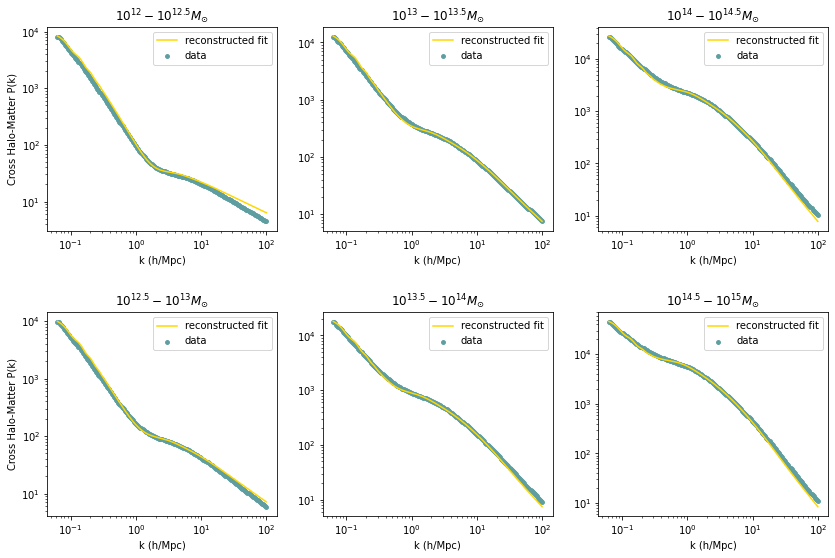

In [45]:
plt.figure(figsize=(14,9))
plt.subplot(231)
plt.scatter(k_emu, p_hm[0], label='data', c='cadetblue', s=15)
plt.plot(k_emu, phm_recons_12a_th, label='reconstructed fit', c='gold')
plt.xlabel('k (h/Mpc)')
plt.ylabel('Cross Halo-Matter P(k)')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$10^{12}-10^{12.5}M_{\odot}$')
plt.legend(loc='best')

plt.subplot(232)
plt.scatter(k_emu, p_hm[2], label='data', c='cadetblue', s=15)
plt.plot(k_emu, phm_recons_13a_th, label='reconstructed fit', c='gold')
plt.xlabel('k (h/Mpc)')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$10^{13}-10^{13.5}M_{\odot}$')
plt.legend(loc='best')

plt.subplot(233)
plt.scatter(k_emu, p_hm[4], label='data', c='cadetblue', s=15)
plt.plot(k_emu, phm_recons_14a_th, label='reconstructed fit', c='gold')
plt.xlabel('k (h/Mpc)')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$10^{14}-10^{14.5}M_{\odot}$')
plt.legend(loc='best')

plt.subplot(234)
plt.scatter(k_emu, p_hm[1], label='data', c='cadetblue', s=15)
plt.plot(k_emu, phm_recons_12b_th, label='reconstructed fit', c='gold')
plt.xlabel('k (h/Mpc)')
plt.ylabel('Cross Halo-Matter P(k)')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$10^{12.5}-10^{13}M_{\odot}$')
plt.legend(loc='best')

plt.subplot(235)
plt.scatter(k_emu, p_hm[3], label='data', c='cadetblue', s=15)
plt.plot(k_emu, phm_recons_13b_th, label='reconstructed fit', c='gold')
plt.xlabel('k (h/Mpc)')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$10^{13.5}-10^{14}M_{\odot}$')
plt.legend(loc='best')

plt.subplot(236)
plt.scatter(k_emu, p_hm[5], label='data', c='cadetblue', s=15)
plt.plot(k_emu, phm_recons_14b_th, label='reconstructed fit', c='gold')
plt.xlabel('k (h/Mpc)')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$10^{14.5}-10^{15}M_{\odot}$')
plt.legend(loc='best')

plt.subplots_adjust(wspace=0.2, hspace=0.4)


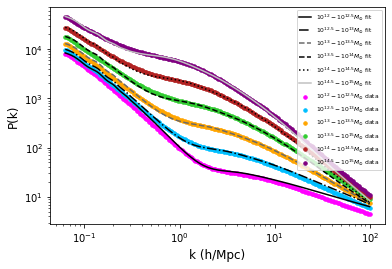

In [46]:
plt.figure()
plt.scatter(k_emu, p_hm[0], label=r'$10^{12}-10^{12.5}M_{\odot}$ data', c='magenta', s=12)
plt.plot(k_emu, phm_recons_12a_th, label=r'$10^{12}-10^{12.5}M_{\odot}$ fit', c='black')
plt.scatter(k_emu, p_hm[1], label=r'$10^{12.5}-10^{13}M_{\odot}$ data', c='deepskyblue', s=12)
plt.plot(k_emu, phm_recons_12b_th, label=r'$10^{12.5}-10^{13}M_{\odot}$ fit', c='black', linestyle='dashdot')
plt.scatter(k_emu, p_hm[2], label=r'$10^{13}-10^{13.5}M_{\odot}$ data', c='orange', s=12)
plt.plot(k_emu, phm_recons_13a_th, label=r'$10^{13}-10^{13.5}M_{\odot}$ fit', c='dimgrey', linestyle='--')
plt.scatter(k_emu, p_hm[3], label=r'$10^{13.5}-10^{15}M_{\odot}$ data', c='limegreen', s=12)
plt.plot(k_emu, phm_recons_13b_th, label=r'$10^{13.5}-10^{14}M_{\odot}$ fit', c='black', linestyle='--')
plt.scatter(k_emu, p_hm[4], label=r'$10^{14}-10^{14.5}M_{\odot}$ data', c='firebrick', s=12)
plt.plot(k_emu, phm_recons_14a_th, label=r'$10^{14}-10^{14.5}M_{\odot}$ fit', c='black', linestyle='dotted')
plt.scatter(k_emu, p_hm[5], label=r'$10^{14.5}-10^{15}M_{\odot}$ data', c='purple', s=12)
plt.plot(k_emu, phm_recons_14b_th, label=r'$10^{14.5}-10^{15}M_{\odot}$ fit', c='silver')
plt.xlabel('k (h/Mpc)', fontsize=12)
plt.ylabel('P(k)', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right', prop={'size':6})
